<ul>
  <li><b><u>country:</u></b> visitor country based on the IP address.</li>
  <li><b><u>age:</u></b> visitor age. Inferred from 3rd party providers</li>
  <li><b><u>new_user:</u></b> whether the visitor has visited the site before, based on cookies, or if they are brand new to the site.</li>
  <li><b><u>source:</u></b> Marketing channel source.
      <ul>
      <li><b>Ads:</b> Came to the site by clicking on an advertisement</li>
      <li><b>Seo:</b> Came to the site by clicking on search results</li>
      <li><b>Direct:</b> Came to the site by directly typing the URL on the browser</li>
    </ul>
  </li>
  <li><b><u>total_pages_visited:</u></b> Number of total pages visited during the session. This can be seen as a proxy for time spent on-site and engagement</li>
  <li><b><u>converted:</u></b> This is our label. 1 means they converted, i.e. created a new account, within the session, 0 means they left without doing so.</li>
</ul> 

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report 

import seaborn as sns

import helper
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = helper.fetch_csv("data_sources/conversion_rates.csv")

In [3]:
helper.perform_data_checks(df_init)


        No missing values found. 

        No duplicate rows found. 

            No outliers found in column 'session_id'. 

            Outliers found in column 'age': 

            No outliers found in column 'new_user'. 

            Outliers found in column 'total_pages_visited': 

            Outliers found in column 'converted': 


In [4]:
lower_hinge, median, upper_hinge, upper_whisker = helper.calculate_boxplot_values(df=df_init, column_name="age")


        lower_hinge = 24.0,
        median = 30.0,
        mean = 30.569857685009488
        upper_hinge = 36.0
        upper_whisker = 54.0
        


<AxesSubplot:xlabel='age'>

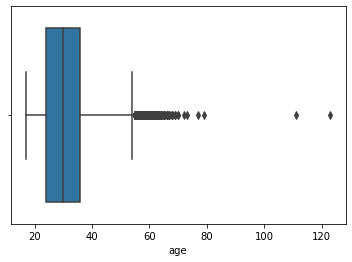

In [8]:

sns.boxplot(df_init["age"])

In [ ]:
df = df_init.groupby(['country', 'age', 'new_user', 'source']).agg(
    count=('session_id', 'count'),
    converted_pages_visited=('total_pages_visited', lambda x: sum(x[df_init['converted'] == True])),
    not_converted_pages_visited=('total_pages_visited', lambda x: sum(x[df_init['converted'] == False])),
    total_pages_visited=('total_pages_visited', 'sum')
).reset_index()

df = df.rename(columns={
    'count': 'total_sessions',
    'converted_pages_visited': 'converted_pages_visited',
    'not_converted_pages_visited': 'not_converted_pages_visited',
    'total_pages_visited': 'total_pages_visited'
})

df = df.reset_index(drop=True)


In [ ]:
helper.plot_linear_regressions(df.groupby(["country", "source", "age_group"]).sum(), 
                               x_axis="total_pages_visited", 
                               y_axis="converted_pages_visited")

In [ ]:
lower_hinge, median, upper_hinge = helper.calculate_boxplot_values(df=df, column_name="age")

In [ ]:
df.loc[df["age"] < lower_hinge, "age_group"] = "q_25"
df.loc[(df["age"] >= lower_hinge) & (df["age"] < median), "age_group"] = "q_50"
df.loc[(df["age"] >= median) & (df["age"] < upper_hinge), "age_group"] = "q_75"
df.loc[(df["age"] >= upper_hinge), "age_group"] = "q_100"

In [ ]:
df

In [ ]:
df["converted"] = df["converted"].astype("bool")
df["new_user"] = df["new_user"].astype("bool")

In [ ]:
df

In [ ]:
#null check
df_nulls = df.isnull().sum().to_frame().reset_index().rename({"index":"column_name", 0: "total_nulls"}, axis = 1)
df_nulls = df_nulls[df_nulls["total_nulls"] > 0]
df_nulls

In [ ]:


df_nulls[["total_nulls"]]

In [ ]:
perform_data_checks(result_df)

In [ ]:
import pandas as pd
import numpy as np

def clean_outliers(df, column_name, threshold=3):
    """
    Verilen sütundaki outlier'ları temizler.

    Parameters:
        df (DataFrame): Outlier temizliği yapılacak DataFrame.
        column_name (str): Outlier temizliği yapılacak sütunun adı.
        threshold (float): Outlier olarak kabul edilecek z puanı eşik değeri. Varsayılan olarak 3.

    Returns:
        cleaned_df (DataFrame): Outlier'ları temizlenmiş DataFrame.
    """
    # Belirtilen sütunu seç
    column = df[column_name]
    
    # Z puanlarını hesapla
    z_scores = (column - column.mean()) / column.std()
    print(z_scores)
    
    # Z puanı eşik değerini aşan outlier'ları tespit et
    outliers = df[abs(z_scores) > threshold]
    
    if not outliers.empty:
        print(f"Outliers found in column '{column_name}':")
        print(outliers)
        
        # Outlier'ları veri çerçevesinden kaldır
        df = df.drop(outliers.index)
    
    else:
        print(f"No outliers found in column '{column_name}'.")
    
    return df


In [ ]:
clean_df = clean_outliers(df, "age", threshold=3)

In [ ]:
clean_df.age.max()

In [ ]:

# Özellikleri ve hedef değişkeni belirleyin
X = df.drop('converted', axis=1)
y = df['converted']

# scaling and one-hot encoding
numeric_columns = ["age", "total_pages_visited"]
categorical_columns = ["country", "source"]
binary_columns = ["new_user", "converted"]

numeric_data_scaler = StandardScaler()
numeric_data_scaler.fit(df[numeric_columns])
scaled_numeric_data = numeric_data_scaler.transform(df[numeric_columns])

model_df = pd.DataFrame(scaled_numeric_data)
model_df.columns = numeric_columns

one_hot_encoded = pd.get_dummies(df[categorical_columns])

model_df = pd.concat([model_df, one_hot_encoded, df[binary_columns]], axis=1)
model_df.dropna(inplace=True)

# split
X = model_df.drop('converted', axis=1)
y = model_df['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Random Forest sınıflandırıcıyı eğitin
rfc = RandomForestClassifier(n_estimators=300, min_samples_split=20, random_state=42)
rfc.fit(X_train, y_train)

# Test verisi üzerinde tahminler yapın ve sonuçları değerlendirin
predictions_rf = rfc.predict(X_test)
print("Random Forest:\n", classification_report(y_test, predictions_rf))